# Reservoir Computers and Echo State Networks

In [8]:
using Pkg
Pkg.activate(".")
import Pkg; Pkg.add("DynamicalSystems")

  Activating project at `~/Documents/Monsoon_reconstruction`


   Resolving package versions...


   Installed MakieCore ──── v0.6.2
   Installed Observables ── v0.5.4


   Installed Polynomials ── v3.2.5
   Installed UnicodePlots ─ v2.5.1


    Updating `~/Documents/Monsoon_reconstruction/Project.toml`
  [61744808] + DynamicalSystems v2.3.2
    Updating `~/Documents/Monsoon_reconstruction/Manifest.toml`


  [621f4979] + AbstractFFTs v1.2.1
  [96374032] + CRlibm v1.0.1
⌅ [608a59af] + ChaosTools v2.9.0
  [aaaa29a8] + Clustering v0.14.3
  [861a8166] + Combinatorics v1.0.2
  [a8cc5b0e] + Crayons v4.1.1
  [717857b8] + DSP v0.7.8
⌅ [5732040d] + DelayEmbeddings v2.4.1
  [61744808] + DynamicalSystems v2.3.2
⌅ [6e36e845] + DynamicalSystemsBase v2.8.0
⌅ [ed8fcbec] + Entropies v1.1.2
  [90fa49ef] + ErrorfreeArithmetic v0.5.2
  [7a1cc6ca] + FFTW v1.5.0
  [fa42c844] + FastRounding v0.3.1
  [d1acc4aa] + IntervalArithmetic v0.20.8
  [d2bf35a9] + IntervalRootFinding v0.5.11
  [c8e1da08] + IterTools v1.4.0
  [fc60dff9] + LombScargle v1.0.3
  [20f20a25] + MakieCore v0.6.2
  [eff96d63] + Measurements v2.8.0
  [b8a86587] + NearestNeighbors v0.4.13
  [645ca80c] + Neighborhood v0.2.4
  [510215fc] + Observables v0.5.4
  [f27b6e38] + Polynomials v3.2.5
  [92933f4c] + ProgressMeter v1.7.2
⌅ [639c3291] + RecurrenceAnalysis v1.8.1
  [f2b01f46] + Roots v2.0.8
  [5eaf0fd0] + RoundingEmulator v0.2.1
  [3cc68bcd] + S

Precompiling project...


  ✓ IntelOpenMP_jll
  ✓ Observables


  ✓ MKL_jll


  ✓ MakieCore


  ✓ UnicodePlots


  ✓ FFTW


  ✓ LombScargle


  ✓ SimpleDiffEq


  ✓ RecurrenceAnalysis


  ✓ Polynomials


  ✓ DynamicalSystemsBase


  ✓ IntervalRootFinding


  ✓ DSP


  ✓ Wavelets


  ✓ Entropies


  ✓ ChaosTools


  ✓ DynamicalSystems
  17 dependencies successfully precompiled in 36 seconds. 290 already precompiled.


In [6]:
Pkg.instantiate()

In [9]:
using DifferentialEquations  # For generating synthetic training data
using DynamicalSystems       # For calculating Lyapunov exponents (a great package with much more to it than this)
using ReservoirComputing     # Julia implementation of reservoir computers
using Printf                 # Nice C-style string formatting
using Plots

[ Info: GR


In [10]:
a = 0.1
Wᵢₙ = WeightedLayer(scaling = a)

WeightedLayer{Float64}(0.1)

In [11]:
reservoir_size = 1000           # Number of nodes in the reservoir
spectral_radius = 1.0           # Good starting value
sparsity = 10 / reservoir_size  # Each node is connected to 10 others, on average

W = RandSparseReservoir(reservoir_size, radius = spectral_radius, sparsity = sparsity)

RandSparseReservoir{Float64, Float64}(1000, 1.0, 0.01)

In [13]:
"""
    generate_esn(input_signal, reservoir_size = 1000, spectral_radius = 1.0, sparsity = 0.1, input_scale = 0.1)

Generate an Echo State Network consisting of the reservoir weights W and the input weights Wᵢₙ.
"""
function generate_esn(
    input_signal,
    reservoir_size = 1000,
    spectral_radius = 1.0,
    sparsity = 0.1,
    input_scale = 0.1,
)
    Wᵢₙ = WeightedLayer(scaling = input_scale)
    W = RandSparseReservoir(reservoir_size, radius = spectral_radius, sparsity = sparsity)
    return ESN(input_signal, reservoir = W, input_layer = Wᵢₙ)
end

generate_esn

In [14]:
ridge_param = 0.0  # OLS
training_method = StandardRidge(ridge_param)

StandardRidge{Float64}(0.0)

- Once again, we define a convenience method to automate this process slightly:

In [16]:
"""
    train_esn!(esn, y, ridge_param)

Given an Echo State Network, train it on the target sequence y_target and return the optimised output weights Wₒᵤₜ.
"""
function train_esn!(esn, y_target, ridge_param)
    training_method = StandardRidge(ridge_param)
    return train(esn, y_target, training_method)
end

train_esn!

In [17]:
"""
    train_val_test_split(data; val_seconds, test_seconds, Δt)

Split the given data into training, validation, and test sets.
"""
function train_val_test_split(data; val_seconds, test_seconds, Δt)
    N_total = size(data, 2)
    N_val = round(Int, val_seconds / Δt)
    N_test = round(Int, test_seconds / Δt)
    
    split_index_1 = N_total - N_test - N_val
    split_index_2 = N_total - N_test
    
    train_data = data[:, 1:split_index_1]
    val_data = data[:, split_index_1+1:split_index_2]
    test_data = data[:, split_index_2+1:end]
    
    return train_data, val_data, test_data
end

train_val_test_split

In [18]:
"""
Hyperparameters for an Echo State Network.
"""
struct ESNHyperparameters
    reservoir_size
    spectral_radius
    sparsity
    input_scale
    ridge_param
end

ESNHyperparameters

In [19]:
param_grid = ESNHyperparameters[]  # Empty list of objects of type ESNHyperparameters

reservoir_sizes = [512, 1024]
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1]
ridge_values = [0.0]  # No noise so OLS is fine

# Take the Cartesian product of the possible hyperparameter values
for params in Iterators.product(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)
    push!(param_grid, ESNHyperparameters(params...))
end

println("$(length(param_grid)) hyperparameter combinations.")

12 hyperparameter combinations.


- Split the data up into training, validation, and test sets.

In [25]:
train_data, val_data, test_data = train_val_test_split(data; val_seconds = 10.0, test_seconds = 10.0, Δt)

([-12.495403374996938 -15.568712145491492 … -14.154832795022278 -6.993554196465272; -19.996994425222717 -11.383248031017645 … -9.950116069438861 0.371483868504328; 21.842429151823175 40.35747513963188 … 38.41384250822928 33.1895294803593], [-1.9103716541398807 -0.29754361154568076 … -1.8239998554714438 -2.2440217999360352; 0.994713089553628 0.44561851329262137 … -1.5379520234911281 -3.328625625121064; 25.08234348356536 19.152102108546355 … 19.782628711272892 15.561648720911464], [-4.151165161386693 -8.50793656462665 … -2.9043744376627725 -5.199674356835135; -7.065430723650543 -14.389154691080533 … -4.246350719991071 -8.619842394020653; 13.336898980168153 16.195280495389966 … 16.300524526038664 14.722802198156312])

In [20]:
"""
    cross_validate_esn(train_data, val_data, param_grid)

Do a grid search on the given param_grid to find the optimal hyperparameters.
"""
function cross_validate_esn(train_data, val_data, param_grid)
    best_loss = Inf
    best_params = nothing

    # We want to predict one step ahead, so the input signal is equal to the target signal from the previous step
    x_train = train_data[:, 1:end-1]
    y_train = train_data[:, 2:end]
        
    for hyperparams in param_grid        
        # Unpack the hyperparameter struct
        (;reservoir_size, spectral_radius, sparsity, input_scale, ridge_param) = hyperparams

        # Generate and train an ESN
        esn = generate_esn(x_train, reservoir_size, spectral_radius, sparsity, input_scale)
        Wₒᵤₜ = train_esn!(esn, y_train, ridge_param)

        # Evaluate the loss on the validation set
        steps_to_predict = size(val_data, 2)
        prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
        loss = sum(abs2, prediction .- val_data)
        
        # Keep track of the best hyperparameter values
        if loss < best_loss
            best_loss = loss
            best_params = hyperparams
        end
    end
    
    println("Optimal hyperparameters: $(best_params)")
    println("Validation loss = ", @sprintf "%.1e" best_loss)
    
    # Retrain the model using the optimal hyperparameters on both the training and validation data
    # This is necessary because we don't want errors accumulated during validation to affect the test error
    (; reservoir_size, spectral_radius, sparsity, input_scale, ridge_param) = best_params
    data = hcat(train_data, val_data)
    x = data[:, 1:end-1]
    y = data[:, 2:end]
    esn = generate_esn(x, reservoir_size, spectral_radius, sparsity, input_scale)
    Wₒᵤₜ = train_esn!(esn, y, ridge_param)
    
    return esn, Wₒᵤₜ
end

cross_validate_esn

In [27]:
@time esn, Wₒᵤₜ = cross_validate_esn(train_data, val_data, param_grid);

Optimal hyperparameters: ESNHyperparameters(512, 1.2, 0.05, 0.1, 0.0)
Validation loss = 7.4e+03
 26.659914 seconds (4.13 M allocations: 816.050 MiB, 0.29% gc time, 5.10% compilation time)


Load Data

In [21]:
using CSV
using DataFrames
using Plots

In [22]:
Pkg.add("NaNStatistics")
using NaNStatistics

   Resolving package versions...


  No Changes to `~/Documents/Monsoon_reconstruction/Project.toml`
  No Changes to `~/Documents/Monsoon_reconstruction/Manifest.toml`


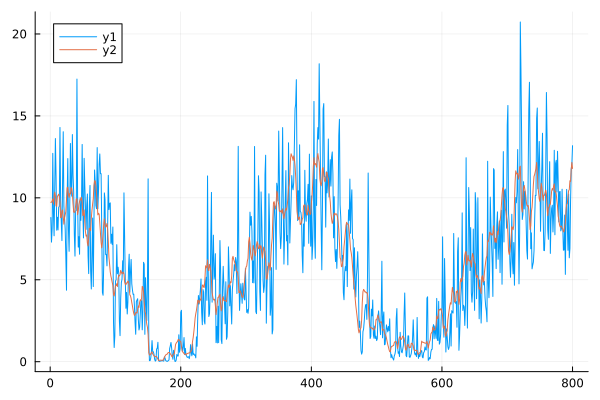

In [24]:
precipitationDaily = zeros(0)
for year in 1979:2019
    filename = "daily_precip_southern_amazonia/" * string(year) * ".csv"
    yearData = Matrix(CSV.read(filename,DataFrame))[:,1]
    precipitationDaily = vcat(precipitationDaily,yearData)
end
plot(precipitationDaily[1:800])
# meanPrecipitationDaily = movmean(precipitationDaily,1)
# plot!(meanPrecipitationDaily[1:800])

function leftMean(array::Vector{Float64},window::Int64)
    return [sum(array[x:x+window-1])/window for x in 1:size(array)[1]-window]
end

window = 10
meanPrecipitationDaily = leftMean(precipitationDaily,window)
plot!(meanPrecipitationDaily[1:800])

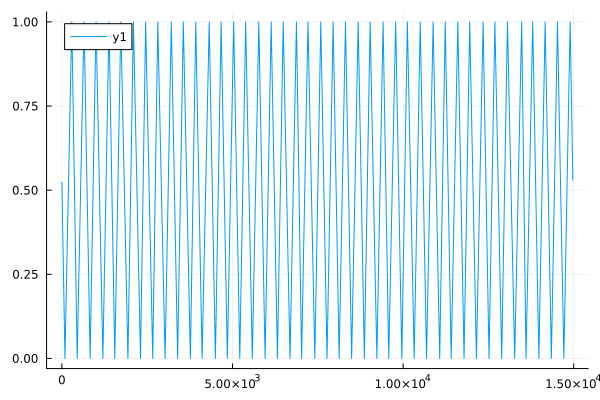

In [26]:
proximityDaily = zeros(0)
filename = "onset_retreat_length/ws_onset.csv"
ws_onset = Matrix(CSV.read(filename,DataFrame, header = false))[:,1]
filename = "onset_retreat_length/ds_onset.csv"
ds_onset = Matrix(CSV.read(filename,DataFrame, header = false))[:,1]
first_ws_onset = ws_onset[end]
first_ws_length = 365 - first_ws_onset + ds_onset[1]
proximityDaily = [1 - (x + (365 - first_ws_onset))/first_ws_length for x in 1:ds_onset[1]]
last_ds_onset = ds_onset[1]

for year in 1979:2019
    if year in [1980,1984,1988,1992,1996,2000,2004,2008,2012,2016]
        days = 366
    else
        days = 365
    end
    ds_length = ws_onset[year - 1979 + 1] - ds_onset[year - 1979 + 1]
    proximityDaily = vcat(proximityDaily,[x/ds_length for x in 1:ds_length])
    if year<2019
        ws_length = days - ws_onset[year - 1979 + 1] + ds_onset[year - 1979 + 1 + 1]
        proximityDaily = vcat(proximityDaily,[1 - x/ws_length for x in 1:ws_length])
    end
end
ws_length = 365 - ws_onset[41] + last_ds_onset
proximityDaily = vcat(proximityDaily,[1-x/ws_length for x in 1:365-ws_onset[41]])
plot(proximityDaily)

(14975,)


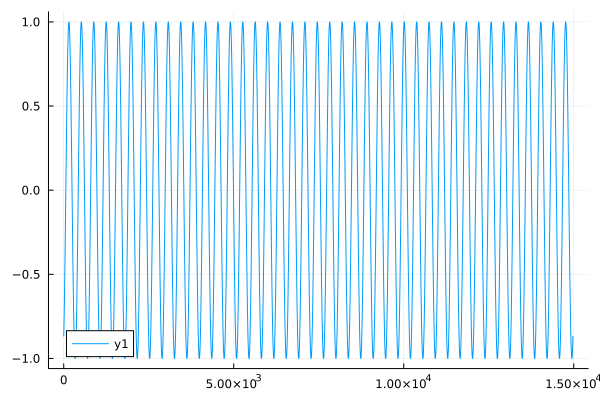

In [27]:
len = size(proximityDaily)
println(len)
t = range(0,len[1])
cosine_signal = cos.(2*π*(t.-152.25)/365.25)
plot(cosine_signal)

Split data

In [28]:
data_x = hcat(meanPrecipitationDaily, cosine_signal[window+1:end-1])'
data_y = proximityDaily[window+1:end]
test_size = 15*365+4
val_size = 5*365+2
dt = 1

# Split precipitation data
train_x = data_x[:,1:test_size]
val_x = data_x[:,test_size+1:test_size+val_size]
test_x = data_x[:,test_size+val_size+1:end]

# Split proximity data
train_y = data_y[1:test_size]
val_y = data_y[test_size+1:test_size+val_size]
test_y = data_y[test_size+val_size+1:end]

7659-element Vector{Float64}:
 0.4776119402985075
 0.47263681592039797
 0.46766169154228854
 0.4626865671641791
 0.4577114427860697
 0.45273631840796025
 0.4477611940298507
 0.4427860696517413
 0.43781094527363185
 0.4328358208955224
 ⋮
 0.5764705882352941
 0.5705882352941176
 0.5647058823529412
 0.5588235294117647
 0.5529411764705883
 0.5470588235294118
 0.5411764705882354
 0.5352941176470588
 0.5294117647058824

Hyperparameter optimization

In [29]:
param_grid = ESNHyperparameters[]  # Empty list of objects of type ESNHyperparameters

reservoir_sizes = [256, 512, 1024]
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1]
ridge_values = [0.0,10^(-10),10^(-8)]  # No noise so OLS is fine

# Take the Cartesian product of the possible hyperparameter values
for params in Iterators.product(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)
    push!(param_grid, ESNHyperparameters(params...))
end

println("$(length(param_grid)) hyperparameter combinations.")

54 hyperparameter combinations.


In [30]:
using Random
using Statistics
#Random.seed!(42)

TaskLocalRNG()

In [31]:
"""
    cross_validate_esn(train_data, val_data, param_grid)

Do a grid search on the given param_grid to find the optimal hyperparameters.
"""
function cross_validate_esn(train_x, val_x, train_y, val_y, param_grid)
    best_loss = Inf
    best_params = nothing

    # We want
    x_train = train_x
    y_train = Array(train_y')
        
    for hyperparams in param_grid        
        # Unpack the hyperparameter struct
        (;reservoir_size, spectral_radius, sparsity, input_scale, ridge_param) = hyperparams

        loss_i = zeros(10)
        for i in 1:10
            # Generate and train an ESN
            esn = generate_esn(x_train, reservoir_size, spectral_radius, sparsity, input_scale)
            Wₒᵤₜ = train_esn!(esn, y_train, ridge_param)

            # Evaluate the loss on the validation set
            steps_to_predict = size(val_y,1)
            #prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
            prediction = esn(Predictive(val_x), Wₒᵤₜ)
            loss_i[i] = sum(abs2, prediction .- Array(val_y'))
        end
        
        # Mean loss
        loss = mean(loss_i)
        
        println("Hyperparameters: $(hyperparams)")
        println("Validation loss = ", @sprintf "%.1e" loss)
        
        
        # Keep track of the best hyperparameter values
        if loss < best_loss
            best_loss = loss
            best_params = hyperparams
        end
    end
    
    println("Optimal hyperparameters: $(best_params)")
    println("Validation loss = ", @sprintf "%.1e" best_loss)
    
    # Retrain the model using the optimal hyperparameters on both the training and validation data
    # This is necessary because we don't want errors accumulated during validation to affect the test error
    (; reservoir_size, spectral_radius, sparsity, input_scale, ridge_param) = best_params
    x = hcat(x_train, val_x) # Check if doesn't work, do array and ' stuff
    y = hcat(y_train, Array(val_y'))
    esn = generate_esn(x, reservoir_size, spectral_radius, sparsity, input_scale)
    Wₒᵤₜ = train_esn!(esn, y, ridge_param)
    
    return esn, Wₒᵤₜ
end

cross_validate_esn

In [32]:
@time esn, Wₒᵤₜ = cross_validate_esn(train_x, val_x, train_y, val_y, param_grid);

Hyperparameters: ESNHyperparameters(256, 0.8, 0.03, 0.1, 0.0)
Validation loss = 4.9e+00
Hyperparameters: ESNHyperparameters(512, 0.8, 0.03, 0.1, 0.0)


Validation loss = 4.9e+00


Hyperparameters: ESNHyperparameters(1024, 0.8, 0.03, 0.1, 0.0)
Validation loss = 6.4e+00
Hyperparameters: ESNHyperparameters(256, 1.0, 0.03, 0.1, 0.0)


Validation loss = 5.2e+00


Hyperparameters: ESNHyperparameters(512, 1.0, 0.03, 0.1, 0.0)
Validation loss = 5.3e+00
Hyperparameters: ESNHyperparameters(1024, 1.0, 0.03, 0.1, 0.0)


Validation loss = 6.3e+00


Hyperparameters: ESNHyperparameters(256, 1.2, 0.03, 0.1, 0.0)
Validation loss = 1.5e+01
Hyperparameters: ESNHyperparameters(512, 1.2, 0.03, 0.1, 0.0)


Validation loss = 1.3e+01


Hyperparameters: ESNHyperparameters(1024, 1.2, 0.03, 0.1, 0.0)
Validation loss = 2.3e+01
Hyperparameters: ESNHyperparameters(256, 0.8, 0.05, 0.1, 0.0)


Validation loss = 4.8e+00


Hyperparameters: ESNHyperparameters(512, 0.8, 0.05, 0.1, 0.0)
Validation loss = 4.8e+00
Hyperparameters: ESNHyperparameters(1024, 0.8, 0.05, 0.1, 0.0)


Validation loss = 6.3e+00


Hyperparameters: ESNHyperparameters(256, 1.0, 0.05, 0.1, 0.0)
Validation loss = 5.2e+00
Hyperparameters: ESNHyperparameters(512, 1.0, 0.05, 0.1, 0.0)


Validation loss = 5.0e+00


Hyperparameters: ESNHyperparameters(1024, 1.0, 0.05, 0.1, 0.0)
Validation loss = 6.2e+00
Hyperparameters: ESNHyperparameters(256, 1.2, 0.05, 0.1, 0.0)


Validation loss = 1.5e+01


Hyperparameters: ESNHyperparameters(512, 1.2, 0.05, 0.1, 0.0)
Validation loss = 1.9e+01
Hyperparameters: ESNHyperparameters(1024, 1.2, 0.05, 0.1, 0.0)


Validation loss = 2.0e+01


Hyperparameters: ESNHyperparameters(256, 0.8, 0.03, 0.1, 1.0e-10)
Validation loss = 5.0e+00
Hyperparameters: ESNHyperparameters(512, 0.8, 0.03, 0.1, 1.0e-10)


Validation loss = 4.8e+00


Hyperparameters: ESNHyperparameters(1024, 0.8, 0.03, 0.1, 1.0e-10)
Validation loss = 6.3e+00
Hyperparameters: ESNHyperparameters(256, 1.0, 0.03, 0.1, 1.0e-10)


Validation loss = 5.3e+00


Hyperparameters: ESNHyperparameters(512, 1.0, 0.03, 0.1, 1.0e-10)
Validation loss = 5.3e+00
Hyperparameters: ESNHyperparameters(1024, 1.0, 0.03, 0.1, 1.0e-10)


Validation loss = 6.1e+00


Hyperparameters: ESNHyperparameters(256, 1.2, 0.03, 0.1, 1.0e-10)
Validation loss = 1.0e+01
Hyperparameters: ESNHyperparameters(512, 1.2, 0.03, 0.1, 1.0e-10)


Validation loss = 1.4e+01


Hyperparameters: ESNHyperparameters(1024, 1.2, 0.03, 0.1, 1.0e-10)
Validation loss = 1.8e+01
Hyperparameters: ESNHyperparameters(256, 0.8, 0.05, 0.1, 1.0e-10)


Validation loss = 5.0e+00


Hyperparameters: ESNHyperparameters(512, 0.8, 0.05, 0.1, 1.0e-10)
Validation loss = 4.8e+00
Hyperparameters: ESNHyperparameters(1024, 0.8, 0.05, 0.1, 1.0e-10)


Validation loss = 6.2e+00


Hyperparameters: ESNHyperparameters(256, 1.0, 0.05, 0.1, 1.0e-10)
Validation loss = 5.7e+00
Hyperparameters: ESNHyperparameters(512, 1.0, 0.05, 0.1, 1.0e-10)


Validation loss = 5.2e+00


Hyperparameters: ESNHyperparameters(1024, 1.0, 0.05, 0.1, 1.0e-10)
Validation loss = 6.0e+00
Hyperparameters: ESNHyperparameters(256, 1.2, 0.05, 0.1, 1.0e-10)


Validation loss = 1.6e+01


Hyperparameters: ESNHyperparameters(512, 1.2, 0.05, 0.1, 1.0e-10)
Validation loss = 1.7e+01
Hyperparameters: ESNHyperparameters(1024, 1.2, 0.05, 0.1, 1.0e-10)


Validation loss = 1.7e+01


Hyperparameters: ESNHyperparameters(256, 0.8, 0.03, 0.1, 1.0e-8)
Validation loss = 4.9e+00
Hyperparameters: ESNHyperparameters(512, 0.8, 0.03, 0.1, 1.0e-8)


Validation loss = 4.7e+00


Hyperparameters: ESNHyperparameters(1024, 0.8, 0.03, 0.1, 1.0e-8)
Validation loss = 5.3e+00
Hyperparameters: ESNHyperparameters(256, 1.0, 0.03, 0.1, 1.0e-8)


Validation loss = 5.4e+00


Hyperparameters: ESNHyperparameters(512, 1.0, 0.03, 0.1, 1.0e-8)
Validation loss = 5.0e+00
Hyperparameters: ESNHyperparameters(1024, 1.0, 0.03, 0.1, 1.0e-8)


Validation loss = 5.8e+00


Hyperparameters: ESNHyperparameters(256, 1.2, 0.03, 0.1, 1.0e-8)
Validation loss = 2.3e+01
Hyperparameters: ESNHyperparameters(512, 1.2, 0.03, 0.1, 1.0e-8)


Validation loss = 1.2e+01


Hyperparameters: ESNHyperparameters(1024, 1.2, 0.03, 0.1, 1.0e-8)
Validation loss = 2.0e+01
Hyperparameters: ESNHyperparameters(256, 0.8, 0.05, 0.1, 1.0e-8)


Validation loss = 4.9e+00


Hyperparameters: ESNHyperparameters(512, 0.8, 0.05, 0.1, 1.0e-8)
Validation loss = 4.7e+00
Hyperparameters: ESNHyperparameters(1024, 0.8, 0.05, 0.1, 1.0e-8)


Validation loss = 5.3e+00


Hyperparameters: ESNHyperparameters(256, 1.0, 0.05, 0.1, 1.0e-8)
Validation loss = 5.3e+00
Hyperparameters: ESNHyperparameters(512, 1.0, 0.05, 0.1, 1.0e-8)


Validation loss = 5.2e+00


Hyperparameters: ESNHyperparameters(1024, 1.0, 0.05, 0.1, 1.0e-8)
Validation loss = 6.3e+00
Hyperparameters: ESNHyperparameters(256, 1.2, 0.05, 0.1, 1.0e-8)


Validation loss = 2.2e+01


Hyperparameters: ESNHyperparameters(512, 1.2, 0.05, 0.1, 1.0e-8)
Validation loss = 1.4e+01
Hyperparameters: ESNHyperparameters(1024, 1.2, 0.05, 0.1, 1.0e-8)


Validation loss = 1.5e+01
Optimal hyperparameters: ESNHyperparameters(512, 0.8, 0.05, 0.1, 1.0e-8)
Validation loss = 4.7e+00
1288.950174 seconds (45.43 M allocations: 36.661 GiB, 0.08% gc time, 0.76% compilation time)

Plot results

In [39]:
"""
    plot_prediction(esn, Wₒᵤₜ, test_data, λ_max)

Given an Echo State Network, plot its predictions versus the given test set.
"""
function plot_prediction(esn, Wₒᵤₜ, test_y, test_x)
    prediction = esn(Predictive(test_x), Wₒᵤₜ)
    steps_to_predict = size(test_x,2)
    
    #label = ["actual" "predicted"]
    times = 1. * collect(0:steps_to_predict)[1:end-1]

    p1 = plot(times[5500:end], Array(test_y)[5500:end], label = "actual", ylabel = "Proximity")
    plot!(times[5500:end], prediction'[5500:end], label = "predicted", dpi = 600)
end

plot_prediction

In [34]:
prediction_w = esn(Predictive(test_x), Wₒᵤₜ)

1×7659 Matrix{Float64}:
 0.50412  0.5009  0.477483  0.466532  …  0.542565  0.532846  0.540096

In [35]:
prediction_w[:]

7659-element Vector{Float64}:
 0.5041196271287873
 0.5008998635299093
 0.4774834614024783
 0.46653156258459205
 0.4602468615639239
 0.44795698834934683
 0.4467222630674996
 0.4428535719554816
 0.442767995253206
 0.45610976086793187
 ⋮
 0.6087495536035732
 0.5845546017124121
 0.572142994485688
 0.5681094536708002
 0.5540087106901979
 0.5456396248903133
 0.5425648255289843
 0.5328456737244522
 0.5400957996647548

In [37]:
# Pkg.add("JLD")
using JLD
save("Prediction_window$window.jld", "w10", prediction_w)
#load("Prediction_w10.jld")["w1"]

In [40]:
plot_prediction(esn, Wₒᵤₜ, test_y, test_x)
savefig("Plot_prediction_w10.png")

"/home/nils/Documents/Monsoon_reconstruction/Plot_prediction_w10.png"

In [257]:
load("Prediction_w1.jld")["w1"]

1×7659 Matrix{Float64}:
 0.490743  0.473955  0.46576  0.439119  …  0.560004  0.564452  0.54972

5479

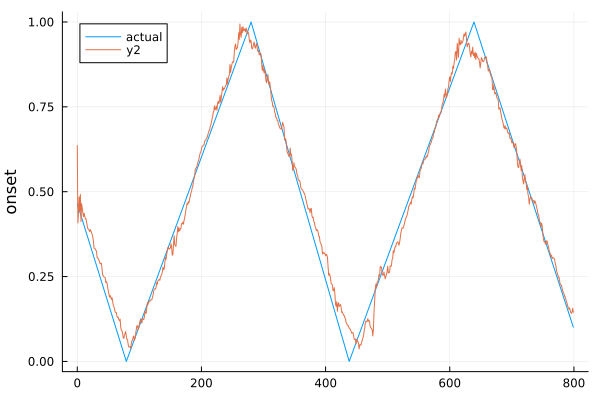

In [48]:
prediction_train = esn(Predictive(train_x), Wₒᵤₜ)
print(size(train_x, 2)[1])
steps_to_predict = size(train_x, 2)[1]
label = ["actual" "predicted"]
times = 1. * collect(0:steps_to_predict)[1:end-1]

p1 = plot(times[1:800], Array(train_y)[1:800], label = label, ylabel = "onset")
plot!(times[1:800], prediction_train'[1:800])